## Maximum Independent Set

In [23]:
## import necessary libraries
import os
import json 
import glob

import networkx as nx
import matplotlib.pyplot as plt

In [24]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo

### Helper Functions

In [25]:

def read_graph_from_file(file_path):
    """
    Reads a graph from a text file and returns the number of nodes, edges, and edge list.

    Parameters:
    - file_path: str, path to the text file containing the graph definition.

    Returns:
    - num_nodes: int, number of nodes in the graph.
    - edges: list of tuple, list of edges in the graph.
    """
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'p':
                num_nodes = int(parts[2])
                num_edges = int(parts[3])
            elif parts[0] == 'e':
                u = int(parts[1]) - 1  # Convert to 0-based index
                v = int(parts[2]) - 1  # Convert to 0-based index
                edges.append((u, v))
    return num_nodes, edges

def create_max_independent_set_model(num_nodes, edges):
    """
    Creates a CPLEX model for the Maximum Independent Set (MIS) problem.

    Parameters:
    - num_nodes: int, the number of nodes in the graph.
    - edges: list of tuple, list of edges in the graph.

    Returns:
    - model: CPLEX model.
    - x: list of CPLEX binary variables representing node selection.
    """
    # Create CPLEX model
    model = Model(name="Maximum Independent Set")

    # Decision variables: x[i] = 1 if node i is in the independent set, 0 otherwise
    x = model.binary_var_list(num_nodes, name="x")

    # Objective: Maximize the number of selected nodes
    model.maximize(model.sum(x[i] for i in range(num_nodes)))

    # Constraints: At most one endpoint of each edge can be in the independent set
    for u, v in edges:
        model.add_constraint(x[u] + x[v] <= 1, f"edge_constraint_{u}_{v}")

    return model, x





In [26]:
def find_simplicials(graph):
    """
    Finds simplicial nodes in the graph.
    A node is simplicial if its neighbors form a clique.

    Parameters:
    - graph: networkx.Graph, the input graph.

    Returns:
    - simplicials: list of simplicial nodes.
    """
    simplicials = []
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        is_simplicial = True
        # Check if all pairs of neighbors are connected
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if not graph.has_edge(neighbors[i], neighbors[j]):
                    is_simplicial = False
                    break
            if not is_simplicial:
                break
        if is_simplicial:
            simplicials.append(node)
    return simplicials


def preprocess_graph(graph):
    """
    Preprocesses the graph to iteratively remove simplicial nodes
    and their neighbors, and visualizes each step.

    Parameters:
    - graph: networkx.Graph, the input graph.

    Returns:
    - reduced_graph: networkx.Graph, the reduced graph after preprocessing.
    - simplicial_nodes: list of nodes fixed in the independent set.
    - original_indices: dict mapping reduced graph indices to original graph indices.
    """
    pos = nx.spring_layout(graph, seed=42)  # Position for consistent visualization
    iteration = 1
    simplicial_nodes = []  # To keep track of simplicial nodes added to the independent set

    while True:
        current_simplicial_nodes = find_simplicials(graph)
        if not current_simplicial_nodes:
            print(f"No more simplicial nodes found. Preprocessing complete.")
            break  # Stop if no simplicial nodes are found

        print(f"Iteration {iteration}: Found {len(current_simplicial_nodes)} simplicial nodes.")

        # Add simplicial nodes to the independent set
        simplicial_nodes.extend(current_simplicial_nodes)

        # Identify nodes to remove (simplicial nodes and their neighbors)
        neighbors_to_remove = set()
        for node in current_simplicial_nodes:
            neighbors_to_remove.update(graph.neighbors(node))
        nodes_to_remove = set(current_simplicial_nodes).union(neighbors_to_remove)

        # Visualize the current state of the graph
        plt.figure(figsize=(10, 8))
        nx.draw(graph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10)
        nx.draw_networkx_nodes(graph, pos, nodelist=current_simplicial_nodes, node_color="red", label="Simplicial Nodes")
        nx.draw_networkx_nodes(graph, pos, nodelist=list(neighbors_to_remove), node_color="yellow", label="Neighbors of Simplicial Nodes")
        plt.title(f"Iteration {iteration}: Removing Simplicial Nodes and Neighbors")
        plt.legend()
        plt.show()

        # Remove the nodes from the graph
        graph.remove_nodes_from(nodes_to_remove)
        iteration += 1

    print(f"Preprocessing complete. Remaining nodes: {list(graph.nodes())}")

    # Create a mapping from reduced graph indices to original indices
    original_indices = {i: node for i, node in enumerate(graph.nodes())}
    return graph, simplicial_nodes, original_indices


def combine_solutions(simplicial_nodes, reduced_solution, original_indices):
    """
    Combines the solution from the simplicial nodes and the reduced graph.

    Parameters:
    - simplicial_nodes: list of nodes fixed in the independent set during preprocessing.
    - reduced_solution: list of nodes in the independent set from the reduced graph solution.
    - original_indices: dict mapping reduced graph indices to original graph indices.

    Returns:
    - full_solution: list of nodes in the full independent set.
    """
    # Map reduced solution back to original graph indices
    mapped_solution = [original_indices[i] for i in reduced_solution]

    # Combine the simplicial nodes with the reduced graph solution
    full_solution = set(simplicial_nodes).union(mapped_solution)
    print(f"Simplicial nodes: {simplicial_nodes}")
    print(f"Reduced graph solution mapped to original indices: {mapped_solution}")
    return sorted(full_solution)

In [27]:
file_path = "mis_benchmark_instances/1dc.64.txt"

In [28]:
num_nodes, edges = read_graph_from_file(file_path)
model, x = create_max_independent_set_model(num_nodes, edges)

In [29]:
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_10 + x_11
      + x_12 + x_13 + x_14 + x_15 + x_16 + x_17 + x_18 + x_19 + x_20 + x_21
      + x_22 + x_23 + x_24 + x_25 + x_26 + x_27 + x_28 + x_29 + x_30 + x_31
      + x_32 + x_33 + x_34 + x_35 + x_36 + x_37 + x_38 + x_39 + x_40 + x_41
      + x_42 + x_43 + x_44 + x_45 + x_46 + x_47 + x_48 + x_49 + x_50 + x_51
      + x_52 + x_53 + x_54 + x_55 + x_56 + x_57 + x_58 + x_59 + x_60 + x_61
      + x_62 + x_63
Subject To
 _edge_constraint_0_1: x_0 + x_1 <= 1
 _edge_constraint_0_2: x_0 + x_2 <= 1
 _edge_constraint_0_4: x_0 + x_4 <= 1
 _edge_constraint_0_8: x_0 + x_8 <= 1
 _edge_constraint_0_16: x_0 + x_16 <= 1
 _edge_constraint_0_32: x_0 + x_32 <= 1
 _edge_constraint_1_2: x_1 + x_2 <= 1
 _edge_constraint_1_3: x_1 + x_3 <= 1
 _edge_constraint_1_4: x_1 + x_4 <= 1
 _edge_constraint_1_5: x_1 + x_5 <= 1
 _edge_constra

### Classically Solve the Model

In [30]:
solution = model.solve()

if solution:
    print("Objective value (size of independent set):", solution.objective_value)
    independent_set = [i + 1 for i in range(num_nodes) if x[i].solution_value > 0.5]  # Convert back to 1-based index
    print("Nodes in the maximum independent set:", independent_set)
else:
    print("No solution found.")

optimal_value = solution.objective_value if solution else None


Objective value (size of independent set): 10.0
Nodes in the maximum independent set: [1, 4, 13, 16, 22, 35, 47, 52, 57, 64]


### QUBO formulation

In [31]:
qp = from_docplex_mp(model)
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)

# number of variables
num_vars = qubo.get_num_vars()
print('Number of variables:', num_vars)

Number of variables: 64


In [32]:
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Minimize
 obj: - x_0 - x_1 - x_2 - x_3 - x_4 - x_5 - x_6 - x_7 - x_8 - x_9 - x_10 - x_11
      - x_12 - x_13 - x_14 - x_15 - x_16 - x_17 - x_18 - x_19 - x_20 - x_21
      - x_22 - x_23 - x_24 - x_25 - x_26 - x_27 - x_28 - x_29 - x_30 - x_31
      - x_32 - x_33 - x_34 - x_35 - x_36 - x_37 - x_38 - x_39 - x_40 - x_41
      - x_42 - x_43 - x_44 - x_45 - x_46 - x_47 - x_48 - x_49 - x_50 - x_51
      - x_52 - x_53 - x_54 - x_55 - x_56 - x_57 - x_58 - x_59 - x_60 - x_61
      - x_62 - x_63 + [ 130 x_0*x_1 + 130 x_0*x_2 + 130 x_0*x_4 + 130 x_0*x_8
      + 130 x_0*x_16 + 130 x_0*x_32 + 130 x_1*x_2 + 130 x_1*x_3 + 130 x_1*x_4
      + 130 x_1*x_5 + 130 x_1*x_8 + 130 x_1*x_9 + 130 x_1*x_16 + 130 x_1*x_17
      + 130 x_1*x_32 + 130 x_1*x_33 + 130 x_2*x_3 + 130 x_2*x_4 + 130 x_2*x_5
      + 130 x_2*x_6 + 130 x_2*x_8 + 130 x_2*x_9 + 130 x_2*x_10 + 130 x_2*x_16
      + 130 x_2*x_17 + 130 x_2*x_18 +

### Preprocess the Graph

In [33]:
G = nx.Graph()
G.add_edges_from(edges)

print(f"Initial graph has {len(G.nodes)} nodes and {len(G.edges)} edges.")


Initial graph has 64 nodes and 543 edges.


Iteration 1: Found 2 simplicial nodes.


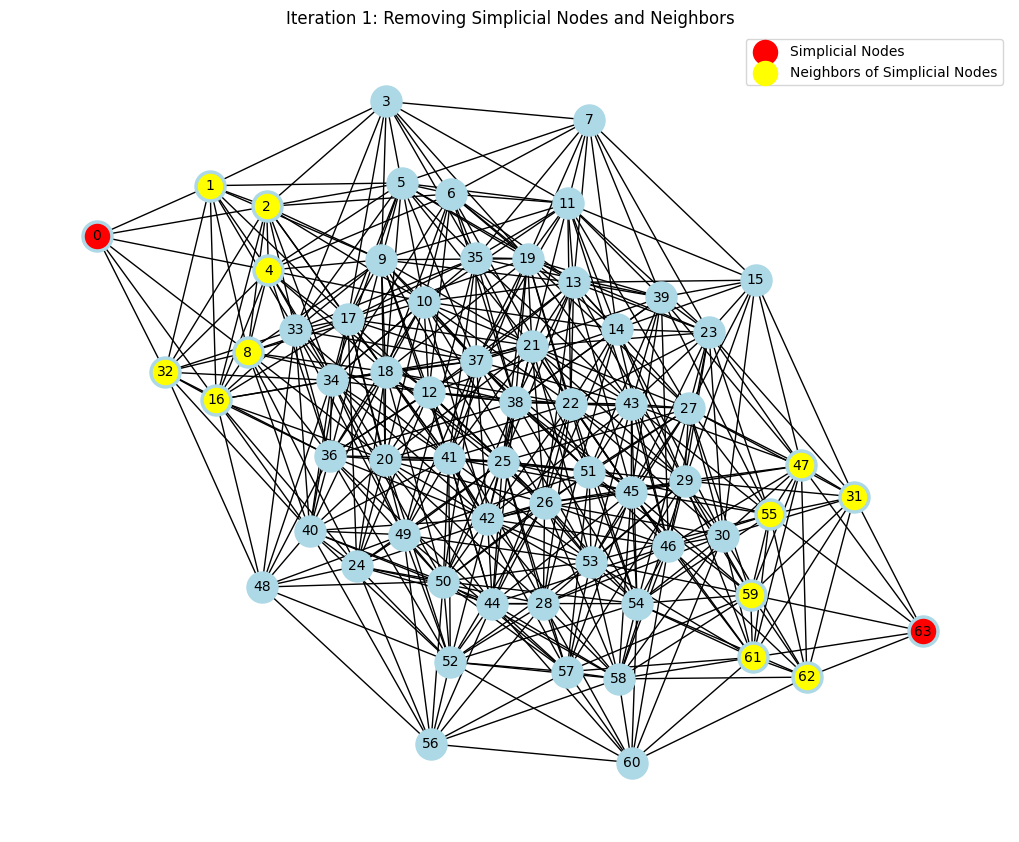

No more simplicial nodes found. Preprocessing complete.
Preprocessing complete. Remaining nodes: [3, 5, 9, 17, 33, 6, 10, 18, 34, 7, 11, 19, 35, 12, 20, 36, 13, 21, 37, 14, 22, 38, 15, 23, 39, 24, 40, 25, 41, 26, 42, 27, 43, 28, 44, 29, 45, 30, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60]
Reduced graph has 50 nodes and 409 edges.


In [34]:
reduced_graph, simplicial_nodes, original_indices = preprocess_graph(G)
print(f"Reduced graph has {len(reduced_graph.nodes)} nodes and {len(reduced_graph.edges)} edges.")


In [35]:
reindexed_graph = nx.convert_node_labels_to_integers(reduced_graph)
model, x = create_max_independent_set_model(len(reindexed_graph.nodes), list(reindexed_graph.edges))


In [36]:
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_10 + x_11
      + x_12 + x_13 + x_14 + x_15 + x_16 + x_17 + x_18 + x_19 + x_20 + x_21
      + x_22 + x_23 + x_24 + x_25 + x_26 + x_27 + x_28 + x_29 + x_30 + x_31
      + x_32 + x_33 + x_34 + x_35 + x_36 + x_37 + x_38 + x_39 + x_40 + x_41
      + x_42 + x_43 + x_44 + x_45 + x_46 + x_47 + x_48 + x_49
Subject To
 _edge_constraint_0_1: x_0 + x_1 <= 1
 _edge_constraint_0_5: x_0 + x_5 <= 1
 _edge_constraint_0_9: x_0 + x_9 <= 1
 _edge_constraint_0_2: x_0 + x_2 <= 1
 _edge_constraint_0_10: x_0 + x_10 <= 1
 _edge_constraint_0_3: x_0 + x_3 <= 1
 _edge_constraint_0_11: x_0 + x_11 <= 1
 _edge_constraint_0_4: x_0 + x_4 <= 1
 _edge_constraint_0_12: x_0 + x_12 <= 1
 _edge_constraint_1_5: x_1 + x_5 <= 1
 _edge_constraint_1_9: x_1 + x_9 <= 1
 _edge_constraint_1_2: x_1 + x_2 <= 1
 _edge_constraint_1_6: x_1 + x_6 <= 1
 _edge_c

### Solve the reduced graph classically

In [37]:
solution = model.solve()

reduced_solution = []
if solution:
    print("Objective value (size of independent set):", solution.objective_value)
    reduced_solution = [i for i in range(len(reindexed_graph.nodes)) if x[i].solution_value > 0.5]
    print("Nodes in the reduced graph independent set:", reduced_solution)
else:
    print("No solution found.")


# Combine solutions
full_solution = combine_solutions(simplicial_nodes, reduced_solution, original_indices)
print("Full independent set solution:", full_solution)
print(f"Size of the full independent set: {len(full_solution)}")

Objective value (size of independent set): 8.0
Nodes in the reduced graph independent set: [0, 8, 13, 17, 22, 38, 42, 46]
Simplicial nodes: [0, 63]
Reduced graph solution mapped to original indices: [3, 34, 12, 21, 15, 46, 51, 56]
Full independent set solution: [0, 3, 12, 15, 21, 34, 46, 51, 56, 63]
Size of the full independent set: 10


In [38]:
qp = from_docplex_mp(model)
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)

# number of variables
num_vars = qubo.get_num_vars()
print('Number of variables:', num_vars)

Number of variables: 50


In [39]:
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Minimize
 obj: - x_0 - x_1 - x_2 - x_3 - x_4 - x_5 - x_6 - x_7 - x_8 - x_9 - x_10 - x_11
      - x_12 - x_13 - x_14 - x_15 - x_16 - x_17 - x_18 - x_19 - x_20 - x_21
      - x_22 - x_23 - x_24 - x_25 - x_26 - x_27 - x_28 - x_29 - x_30 - x_31
      - x_32 - x_33 - x_34 - x_35 - x_36 - x_37 - x_38 - x_39 - x_40 - x_41
      - x_42 - x_43 - x_44 - x_45 - x_46 - x_47 - x_48 - x_49 + [ 102 x_0*x_1
      + 102 x_0*x_2 + 102 x_0*x_3 + 102 x_0*x_4 + 102 x_0*x_5 + 102 x_0*x_9
      + 102 x_0*x_10 + 102 x_0*x_11 + 102 x_0*x_12 + 102 x_1*x_2 + 102 x_1*x_3
      + 102 x_1*x_4 + 102 x_1*x_5 + 102 x_1*x_6 + 102 x_1*x_7 + 102 x_1*x_8
      + 102 x_1*x_9 + 102 x_1*x_10 + 102 x_1*x_11 + 102 x_1*x_12 + 102 x_1*x_16
      + 102 x_1*x_17 + 102 x_1*x_18 + 102 x_2*x_3 + 102 x_2*x_4 + 102 x_2*x_6
      + 102 x_2*x_7 + 102 x_2*x_10 + 102 x_2*x_11 + 102 x_2*x_13 + 102 x_2*x_14
      + 102 x_2*x_15 + 102 x_2*x

Any method like `QAOA` or `VQE` or similar methods can be applied from here on.